In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import cv2

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive (2).zip to archive (2).zip


In [ ]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['archive (2).zip']), 'r')
data.extractall()

In [ ]:
df = pd.read_csv("/content/data.csv")
df.head()

,images_id,label
0,real_1,real
1,real_10,real
2,real_100,real
3,real_101,real
4,real_102,real


In [ ]:
df["label"] = df["label"].replace(["real", "fake"], [1, 0])

<ipython-input-6-55da6389baa4>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["label"].replace(["real", "fake"], [1, 0])


In [ ]:
def get_image_path(image_id):
    if image_id.startswith("real"):
        return  "/content/real"+"/"+image_id +".jpg"
    else:
        return "/content/fake" + "/"+image_id +".jpg"


In [ ]:
df["path"] = df["images_id"].apply(get_image_path)
df.head()

,images_id,label,path
0,real_1,1,/content/real/real_1.jpg
1,real_10,1,/content/real/real_10.jpg
2,real_100,1,/content/real/real_100.jpg
3,real_101,1,/content/real/real_101.jpg
4,real_102,1,/content/real/real_102.jpg


In [ ]:
x = np.empty((1289, 300, 300, 3), dtype = np.uint8)
for i in range(1289):
    image_path = df.iloc[i]["path"]
    image = Image.open(image_path)
    image_array = np.array(image)
    x[i] = image_array

In [ ]:
from sklearn.utils import resample

real_data = df[df['label'] == 1]
fake_data = df[df['label'] == 0]

fake_data_upsampled = resample(fake_data,
                               replace=True,
                               n_samples=len(real_data),
                               random_state=42)

df_balanced = pd.concat([real_data, fake_data_upsampled])

print(df_balanced['label'].value_counts())  # Artırma sonrası kontrol


label
1    589
0    589
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

x_train, x_test, y_train, y_test = train_test_split(x, df["label"], test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(300, 300, 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=32,
    validation_data=(x_test, y_test),
    epochs=20 )

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 760ms/step - accuracy: 0.5847 - loss: 526.7891 - val_accuracy: 0.9457 - val_loss: 14.7783
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9312 - loss: 14.8097 - val_accuracy: 0.8915 - val_loss: 13.2991
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.9368 - loss: 13.0159 - val_accuracy: 0.7287 - val_loss: 11.9877
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.8150 - loss: 11.8413 - val_accuracy: 0.9767 - val_loss: 10.6022
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.9653 - loss: 10.3840 - val_accuracy: 0.8178 - val_loss: 10.2859
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.9658 - loss: 9.4992 - val_accuracy: 0.9729 - val_loss: 8.8271
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.9906 - loss: 8.6027 - val_accuracy: 0.9922 - val_loss: 8.0912
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9954 - loss: 7.8703 -

In [ ]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)


accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report= classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)
print(report)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Accuracy: 1.0
Confusion Matrix:
 [[130   0]
 [  0 128]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00       128

    accuracy                           1.00       258
   macro avg       1.00      1.00      1.00       258
weighted avg       1.00      1.00      1.00       258

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00       128

    accuracy                           1.00       258
   macro avg       1.00      1.00      1.00       258
weighted avg       1.00      1.00      1.00       258



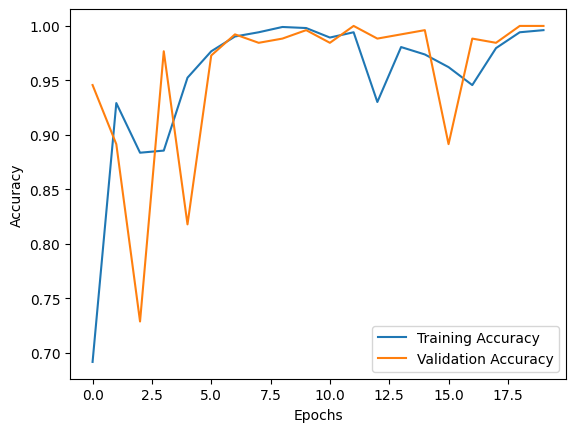

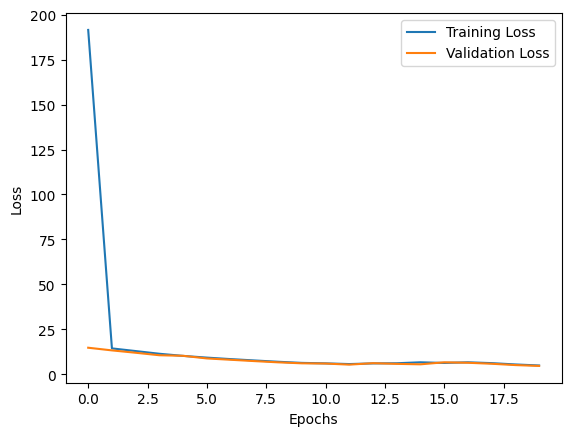

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama başarısını görselleştirme
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybını görselleştirme
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/fakevsreall.h5')

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
from google.colab import files


model = load_model('/content/drive/MyDrive/fakevsreall.h5')

def predict_image_from_upload():

    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    img = Image.open(image_path).convert('RGB')
    img = img.resize((300, 300))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    probability = prediction[0][0]

    print(f"Tahmin olasılığı: {probability:.2f}")
    if probability > 0.5:
        print("Bu fotoğraf GERÇEK olarak tahmin edildi.")
    else:
        print("Bu fotoğraf SAHTE olarak tahmin edildi.")



predict_image_from_upload()

